In [8]:
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForMaskedLM
import tensorflow as tf
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.ERROR)
from transformers import TFAlbertForSequenceClassification

In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', do_lower_case=True)
model = TFBertForSequenceClassification.from_pretrained("bert-base-chinese")

Some layers from the model checkpoint at bert-base-chinese were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier', 'dropout_194']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
max_length = 128
batch_size = 16
def count(filename):
    #f = open(filename.decode('ascii'))
    f = open(filename.decode('utf-8'), encoding="utf-8")
    line = f.readline()
    while line:
        bert_input = tokenizer.encode_plus(
                            line,                      
                            add_special_tokens = True, 
                            max_length = max_length, 
                            padding = 'max_length', 
                            truncation = True,
                            return_attention_mask = True, 
                            )
        yield bert_input['input_ids'],bert_input['token_type_ids'],bert_input['attention_mask']
        line = f.readline()
    f.close()
def mymap(x,label):
    return {
      "input_ids": x[0],
      "token_type_ids": x[1],
      "attention_mask": x[2],}, [label]

In [7]:
print('label : 0')
f = open('zh0.txt', encoding="utf-8")
for i in range(2):
    print(f.readline())
f.close()
print('='*100)
print('label : 1')
f = open('zh1.txt', encoding="utf-8")
for i in range(2):
    print(f.readline())
f.close()

label : 0
标准间太差房间还不如3星的而且设施非常陈旧.建议酒店把老的标准间从新改善.

服务态度极其差，前台接待好象没有受过培训，连基本的礼貌都不懂，竟然同时接待几个客人；大堂副理更差，跟客人辩解个没完，要总经理的电话投诉竟然都不敢给。要是没有作什么亏心事情，跟本不用这么怕。

label : 1
距离川沙公路较近,但是公交指示不对,如果是"蔡陆线"的话,会非常麻烦.建议用别的路线.房间较为简单.

商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!



In [12]:
data = tf.data.Dataset.from_generator(count,args=['zh0.txt'],output_types=tf.int32,output_shapes=(3,max_length),)
data0 = data.map(lambda x: mymap(x, 0))
data = tf.data.Dataset.from_generator(count,args=['zh1.txt'],output_types=tf.int32,output_shapes=(3,max_length),)
data1 = data.map(lambda x: mymap(x, 1))
all_data = data0.concatenate(data1).shuffle(99999)

DATASET_SIZE = len(list(all_data))
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)
train_dataset = all_data.take(train_size).batch(batch_size)
test_dataset = all_data.skip(train_size).take(test_size).batch(batch_size)
val_dataset = all_data.skip(train_size+test_size).batch(batch_size)

In [33]:
learning_rate = 3e-5
number_of_epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(train_dataset, epochs=number_of_epochs, verbose=1,
                    callbacks=[callback],validation_data=val_dataset)

Epoch 1/10
317/317 [==============================] - 286s 902ms/step - loss: 0.2875 - accuracy: 0.8772 - val_loss: 0.2308 - val_accuracy: 0.9245
Epoch 2/10
317/317 [==============================] - 283s 891ms/step - loss: 0.2046 - accuracy: 0.9246 - val_loss: 0.1484 - val_accuracy: 0.9401
Epoch 3/10
317/317 [==============================] - 283s 892ms/step - loss: 0.1529 - accuracy: 0.9435 - val_loss: 0.0777 - val_accuracy: 0.9733
Epoch 4/10
317/317 [==============================] - 283s 893ms/step - loss: 0.1031 - accuracy: 0.9635 - val_loss: 0.0830 - val_accuracy: 0.9742


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


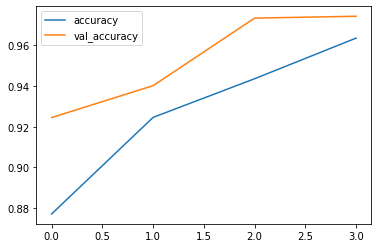

In [34]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy']) 
plt.show()

In [35]:
print(model.evaluate(train_dataset))
print(model.evaluate(val_dataset))
print(model.evaluate(test_dataset))

317/317 [==============================] - 91s 287ms/step - loss: 0.0723 - accuracy: 0.9765
[0.07230205833911896, 0.97650545835495]
68/68 [==============================] - 19s 285ms/step - loss: 0.0688 - accuracy: 0.9761
[0.06884213536977768, 0.9760589599609375]
68/68 [==============================] - 19s 283ms/step - loss: 0.0567 - accuracy: 0.9788
[0.056712619960308075, 0.9788018465042114]


把BERT模型換成ALBERT模型

In [36]:
tokenizer = BertTokenizer.from_pretrained('voidful/albert_chinese_base', do_lower_case=True)
model = TFAlbertForSequenceClassification.from_pretrained("voidful/albert_chinese_base", from_pt = True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertForSequenceClassification: ['predictions.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [37]:
learning_rate = 3e-5
number_of_epochs = 12
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(train_dataset, epochs=number_of_epochs, verbose=1,
                    callbacks=[callback],validation_data=val_dataset)

Epoch 1/12
317/317 [==============================] - 257s 810ms/step - loss: 0.3925 - accuracy: 0.8211 - val_loss: 0.2790 - val_accuracy: 0.8775
Epoch 2/12
317/317 [==============================] - 253s 797ms/step - loss: 0.2498 - accuracy: 0.9013 - val_loss: 0.1797 - val_accuracy: 0.9319
Epoch 3/12
317/317 [==============================] - 253s 797ms/step - loss: 0.1861 - accuracy: 0.9309 - val_loss: 0.1687 - val_accuracy: 0.9374
Epoch 4/12
317/317 [==============================] - 252s 796ms/step - loss: 0.1669 - accuracy: 0.9374 - val_loss: 0.1038 - val_accuracy: 0.9687
Epoch 5/12
317/317 [==============================] - 252s 796ms/step - loss: 0.1335 - accuracy: 0.9524 - val_loss: 0.0856 - val_accuracy: 0.9733
Epoch 6/12
317/317 [==============================] - 252s 795ms/step - loss: 0.0974 - accuracy: 0.9672 - val_loss: 0.0581 - val_accuracy: 0.9834
Epoch 7/12
317/317 [==============================] - 254s 801ms/step - loss: 0.0924 - accuracy: 0.9690 - val_loss: 0.0660 -

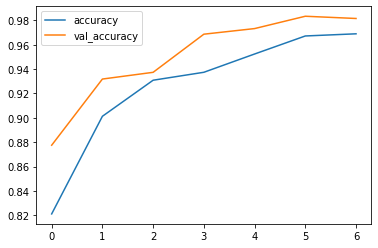

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy']) 
plt.show()

In [39]:
print(model.evaluate(train_dataset))
print(model.evaluate(val_dataset))
print(model.evaluate(test_dataset))

317/317 [==============================] - 85s 267ms/step - loss: 0.0631 - accuracy: 0.9767
[0.06313611567020416, 0.976702868938446]
68/68 [==============================] - 18s 265ms/step - loss: 0.0540 - accuracy: 0.9761
[0.05401749908924103, 0.9760589599609375]
68/68 [==============================] - 18s 265ms/step - loss: 0.0701 - accuracy: 0.9742
[0.070110023021698, 0.9741935729980469]
